In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
%matplotlib inline

import seaborn as sns
# 自作ライブラリは流石に情報共有が大変なんで、書き直し
#from BaseBlocks import BaseBlocks

import string
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from matplotlib_venn import venn2
import lightgbm as lgb
import xgboost as xgb
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
from sklearn.model_selection import KFold, StratifiedKFold

from xfeat import (SelectCategorical, LabelEncoder, Pipeline, ConcatCombination, SelectNumerical, 
                   ArithmeticCombinations, TargetEncoder, aggregation, GBDTFeatureSelector, GBDTFeatureExplorer)
from geopy.distance import geodesic


from contextlib import contextmanager
from time import time

import warnings
warnings.simplefilter('ignore')

In [2]:
#utils

# set seed
def seed_everything(seed=71):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time()
    yield
    d = time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)
        
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [3]:
train_df = pd.read_csv("../input/DC_train.csv")
test_df = pd.read_csv("../input/DC_test.csv")
submission_df = pd.read_csv("../input/DC_output_sample.csv")

# add_data
tracts_df = pd.read_csv("../input/raw_census_tracts_in_2010.csv")
tracts_df = tracts_df.rename(columns={"TRACT":"CENSUS_TRACT"})
#tracts_df = tracts_df[["CENSUS_TRACT","P0010001", "P0010002", "P0010003", "P0010004", "FAGI_TOTAL_2015", "FAGI_MEDIAN_2015"]]

#train_df = pd.merge(train_df, tracts_df, on="CENSUS_TRACT", how="left")
#test_df = pd.merge(test_df, tracts_df, on="CENSUS_TRACT", how="left")

In [4]:
seed_everything(71)

In [5]:
#1ドルってデータがある。
# これはおかしくないか？→削除
train_df = train_df[train_df['PRICE']!=1]

# 低い金額の予測結果がよろしくないので、削除
# 説明性が必要なので、調査
train_df = train_df[np.log1p(train_df["PRICE"])>=10]

# exp13
train_df = train_df[np.log1p(train_df["PRICE"])<=16]

In [6]:
# キッチンの異常値処理
# 44→4
train_df.loc[train_df["KITCHENS"]>40, "KITCHENS"] = 4

# 暖炉数の異常値処理
# SQUEREの値と一致しているのでコピーとかのミス？
# このデータは除外する
train_df = train_df[train_df["FIREPLACES"]<11]
test_df.loc[test_df["FIREPLACES"]>10, "FIREPLACES"] = 1

# HF_BATHRMの異常値削除（1件）
train_df = train_df[train_df["HF_BATHRM"]<10]

# YR_RMDLの異常値除外
train_df["YR_RMDL"].replace(20, 2000, inplace=True)

#後ろの処理のためにAYBの欠損補完 
train_df['AYB'].fillna(train_df['AYB'].mean(), inplace=True)
test_df['AYB'].fillna(test_df['AYB'].mean(), inplace=True)


# ROOMSの異常値？除外
train_df = train_df[train_df["ROOMS"]<25]

# STORIESの異常値処理(階数)
train_df.loc[train_df["STORIES"]>10, "STORIES"] = 8
test_df.loc[test_df["STORIES"]>10, "STORIES"] = 8

# ACの処理
train_df["AC"] = train_df["AC"].apply(lambda x: 1 if x=="Y" else 0)
test_df["AC"] = test_df["AC"].apply(lambda x: 1 if x=="Y" else 0)

#GBA
train_df = train_df[train_df["GBA"].fillna(0)<15000]
train_df = train_df[train_df["LIVING_GBA"].fillna(0)<6000]

# GBAは、ResidentialとCondominiumでcolumnに記録するデータが異なるのでまとめる処理
train_df["modified_GBA"] = train_df["GBA"].fillna(0) + train_df["LIVING_GBA"].fillna(0)
test_df["modified_GBA"] = test_df["GBA"].fillna(0) + test_df["LIVING_GBA"].fillna(0)

# GRADE
replace_list = ["Exceptional-A", "Exceptional-B", "Exceptional-C", "Exceptional-D"]

train_df = train_df[train_df["GRADE"]!="No Data"]
train_df["GRADE"] = train_df["GRADE"].replace(replace_list, "Exceptionals")
test_df["GRADE"] = test_df["GRADE"].replace(replace_list, "Exceptionals")

# LANDAREAの異常値削除
# exp13
train_df = train_df[train_df["LANDAREA"]<75000]
test_df.loc[test_df["LANDAREA"]>30000, "LANDAREA"]=23000


## カテゴリデータ
heat_col = ["Ind Unit", "Gravity Furnac", "Evp Cool", "Air Exchng","No Data"]
train_df["HEAT"] = train_df["HEAT"].replace(heat_col, "Other")
test_df["HEAT"] = test_df["HEAT"].replace(heat_col, "Other")

# convert dtype
train_df["ZIPCODE"] = train_df["ZIPCODE"].astype(str)
test_df["ZIPCODE"] = test_df["ZIPCODE"].astype(str)

train_df["CENSUS_TRACT"] = train_df["CENSUS_TRACT"].astype(str)
test_df["CENSUS_TRACT"] = test_df["CENSUS_TRACT"].astype(str)

# exp13...?
train_df["USECODE"] = train_df["USECODE"].astype(str)
test_df["USECODE"] = test_df["USECODE"].astype(str)

# "QUADRANT"の欠損値補間
fillna_list_tr = train_df[train_df["QUADRANT"].isnull()].Id.tolist()
fillna_list_ts = test_df[test_df["QUADRANT"].isnull()].Id.tolist()

for i in fillna_list_tr:
  fill_qued =train_df[train_df["Id"]==i]["FULLADDRESS"].str[-2:]
  train_df.loc[train_df["Id"]==i, "QUADRANT"] = fill_qued

for i in fillna_list_ts:
  fill_qued =test_df[test_df["Id"]==i]["FULLADDRESS"].str[-2:]
  test_df.loc[test_df["Id"]==i, "QUADRANT"] = fill_qued

In [7]:
# 住宅タイプで分割する
tr_Con = train_df[train_df["SOURCE"]=="Condominium"]
tr_Res = train_df[train_df["SOURCE"]=="Residential"]

ts_Con = test_df[test_df["SOURCE"]=="Condominium"]
ts_Res = test_df[test_df["SOURCE"]=="Residential"]

In [8]:
# exp14.1
# Residentialだけ、販売年（2012年以降）で抽出

tr_Res["SALEDATE"] = pd.to_datetime(tr_Res["SALEDATE"])
tr_Res["SALEYR"] = tr_Res["SALEDATE"].dt.year
tr_Res = tr_Res[tr_Res["SALEYR"]>=2012]
tr_Res = tr_Res.drop("SALEYR", axis=1)

# exp20.1
tr_Res = tr_Res[np.log1p(tr_Res["PRICE"])>=11]

In [9]:
print(tr_Con.shape)
print(tr_Res.shape)

(33097, 50)
(17627, 50)


In [10]:
# BaseBlock
class BaseBlock(object):
    def fit(self, input_df, y=None):
        return self.transform(input_df)
    
    def transform(self, input_df):
        raise NotImplementedError()
        
# CountEncoding
class CountEncodingBlock(BaseBlock):
    def __init__(self, cols):
        self.cols = cols
        self.encoder = None
        
    def fit(self, input_df, y=None):
        return self.transform(input_df[self.cols])
    
    def transform(self, input_df):
        self.encoder = ce.CountEncoder()
        self.encoder.fit(input_df[self.cols])
        return self.encoder.transform(input_df[self.cols]).add_prefix("CE_")
    
# OneHotEncoding
class OneHotEncodingBlock(BaseBlock):
    def __init__(self, cols):
        self.cols = cols
        self.encoder = None
        
    def fit(self, input_df, y=None):
        self.encoder = ce.OneHotEncoder(use_cat_names=True)
        self.encoder.fit(input_df[self.cols])
        return self.transform(input_df[self.cols])
    
    def transform(self, input_df):
        return self.encoder.transform(input_df[self.cols]).add_prefix("OHE_")

# OrdinalEncoding
class OrdinalEncodingBlock(BaseBlock):
    def __init__(self, cols):
        self.cols = cols
        self.encoder = None
        
    def fit(self, input_df, y=None):
        self.encoder = ce.OrdinalEncoder()
        self.encoder.fit(input_df[self.cols])
        return self.transform(input_df[self.cols])
    
    def transform(self, input_df):
        return self.encoder.transform(input_df[self.cols]).add_prefix("OE_")

In [11]:
def get_ce_features_for_condominium(input_df):
    _input_df = pd.concat([input_df], axis=1)
    
    cols = [
        'HEAT',
        'QUALIFIED',
        #'STYLE',
        #'STRUCT',
        #'GRADE',
        #'CNDTN',
        #'EXTWALL',
        #'ROOF',
        #'INTWALL',
        #'GIS_LAST_MOD_DTTM',
        #'SOURCE',
        'ASSESSMENT_NBHD',
        'WARD',
        'QUADRANT',
        'ZIPCODE',
        'CENSUS_TRACT',
        'USECODE'
    ]
    
    encoder = CountEncodingBlock(cols = cols)
    output_df = encoder.fit(_input_df.astype(str))
    return output_df

def get_oe_features_for_condominium(input_df):
    _input_df = pd.concat([input_df], axis=1)
    cols = [
        'HEAT',
        'QUALIFIED',
        #'STYLE',
        #'STRUCT',
        #'GRADE',
        #'CNDTN',
        #'EXTWALL',
        #'ROOF',
        #'INTWALL',
        #'GIS_LAST_MOD_DTTM',
        #'SOURCE',
        'ASSESSMENT_NBHD',
        'WARD',
        'QUADRANT',
        'ZIPCODE',
        'CENSUS_TRACT',
        'USECODE'
    ]
    encoder = OrdinalEncodingBlock(cols = cols)
    output_df = encoder.fit(_input_df)
    return output_df

# not use
def get_ohe_features_for_condominium(input_df):
    _input_df = pd.concat([input_df], axis=1)
    cols = [
        'HEAT',
        'QUALIFIED',
        'STYLE',
        'STRUCT',
        'GRADE',
        'CNDTN',
        #'EXTWALL',
        #'ROOF',
        #'INTWALL',
        #'GIS_LAST_MOD_DTTM',
        #'SOURCE',
        'ASSESSMENT_NBHD',
        'WARD',
        'QUADRANT',
        'ZIPCODE',
        'CENSUS_TRACT',
        'USECODE'
    ]
    encoder = OneHotEncodingBlock(cols=cols)
    output_df = encoder.fit(_input_df)
    return output_df

# numeric_feature
def create_numeric_feature_for_condominium(input_df):
    use_columns = [
        'AC',
        'BATHRM',
        'HF_BATHRM',
        #'NUM_UNITS',
        'ROOMS',
        'BEDRM',
        'AYB',
        'YR_RMDL',
        'EYB',
        #'STORIES',
        'SALE_NUM',
        #'GBA',
        #'BLDG_NUM',
        #'KITCHENS',
        'FIREPLACES',
        #'USECODE',
        'LANDAREA',
        'CMPLX_NUM',
        #'LIVING_GBA',
        #'ZIPCODE',
        #'LATITUDE',
        #'LONGITUDE',
        #'CENSUS_TRACT',
        "modified_GBA",
        #"P0010001", "P0010002", "P0010003", "P0010004", "FAGI_TOTAL_2015", "FAGI_MEDIAN_2015"
    ]

    return input_df[use_columns].copy()

In [43]:
# 一番、平均価格が高そうな地域の平均座標
def get_distance_for_cond(x1, x2):
    master=(38.908246, -77.057431)
    dis = geodesic(master, (x1, x2)).km
    return dis

def get_dis_feature(input_df):
    output_df = input_df.copy()
    output_df["distance"] = input_df[["LATITUDE", "LONGITUDE"]].apply(lambda x: get_distance_for_cond(x[0], x[1]), axis=1)

    return output_df["distance"]

# exp35

def same_conds(input_df):
    _df = input_df.copy()
    count_df = _df.groupby(["LATITUDE", "LONGITUDE"]).count()["Id"].reset_index().rename(columns={"Id":"cond_count"})
    output_df = pd.merge(_df, count_df, on=["LATITUDE", "LONGITUDE"], how="left")
    
    return output_df["cond_count"]

In [44]:
def all_bathrm(input_df):
    output_df = pd.DataFrame()
    output_df["ALL_BATHRM"] = input_df["BATHRM"] + input_df["HF_BATHRM"]

    return output_df

# exp35
def other_room(input_df):
    output_df = pd.DataFrame()
    output_df["Other_room"] = input_df["ROOMS"] - input_df["BEDRM"]
    return output_df

def get_house_age(input_df):
    output_df = pd.DataFrame()
    output_df["house_age"] = 2018 - input_df['AYB']

    return output_df

def get_house_age2(input_df):
    output_df = pd.DataFrame()
    output_df["house_age2"] = 2018 - input_df['EYB']

    return output_df

# exp15
def get_rf_age(input_df):
    output_df = pd.DataFrame()
    output_df["rf_age"] = 2018 - input_df["YR_RMDL"]

    return output_df

def get_sales_date(input_df):
    _df = input_df.copy()
    _df['SALEDATE'] = pd.to_datetime(_df['SALEDATE'])
    output_df = pd.DataFrame()
    output_df["Sale_Year"] = _df['SALEDATE'].dt.year
    output_df["Sale_Month"] = _df['SALEDATE'].dt.month

    return output_df

# CV 向上、LB低下
def get_agg_zipcode_features(input_df):
  
    _input_df = input_df.copy()
    _input_df["house_age"] = 2018 - _input_df['AYB']
  #_input_df['SALEDATE'] = pd.to_datetime(_input_df['SALEDATE'])
  #_input_df["Sale_Year"] = _input_df['SALEDATE'].dt.year

    cols = 'ZIPCODE'

    output_df = pd.DataFrame()
    output_df, agg_cols = aggregation(_input_df,
                                    group_key=cols,
                                    group_values=["BATHRM", "HF_BATHRM", "ROOMS", "modified_GBA"],
                                    agg_methods=["median", "mean", "std",],
                                    )
  
    return output_df[agg_cols]

def get_agg_ward_features(input_df):
  
    _input_df = input_df.copy()
    _input_df["house_age"] = 2018 - _input_df['AYB']
  #_input_df['SALEDATE'] = pd.to_datetime(_input_df['SALEDATE'])
  #_input_df["Sale_Year"] = _input_df['SALEDATE'].dt.year

    cols = 'WARD'

    output_df = pd.DataFrame()
    output_df, agg_cols = aggregation(_input_df,
                                    group_key=cols,
                                    group_values=["BATHRM", "HF_BATHRM", "ROOMS", "modified_GBA"],
                                    agg_methods=["median", "mean", "std",],
                                    )
  
    return output_df[agg_cols]


def get_agg_qual_features(input_df):
  
    _input_df = input_df.copy()
    _input_df["house_age"] = 2018 - _input_df['AYB']
  #_input_df['SALEDATE'] = pd.to_datetime(_input_df['SALEDATE'])
  #_input_df["Sale_Year"] = _input_df['SALEDATE'].dt.year

    cols = 'QUALIFIED'

    output_df = pd.DataFrame()
    output_df, agg_cols = aggregation(_input_df,
                                    group_key=cols,
                                    group_values=["BATHRM", "HF_BATHRM", "ROOMS", "modified_GBA"],
                                    agg_methods=["median", "mean", "std",],
                                    )
  
    return output_df[agg_cols]

def get_agg_track_features(input_df):
  
    _input_df = input_df.copy()
    _input_df["house_age"] = 2018 - _input_df['AYB']
    #_input_df['SALEDATE'] = pd.to_datetime(_input_df['SALEDATE'])
    #_input_df["Sale_Year"] = _input_df['SALEDATE'].dt.year

    cols = 'CENSUS_TRACT'

    output_df = pd.DataFrame()
    output_df, agg_cols = aggregation(_input_df,
                                    group_key=cols,
                                    group_values=["BATHRM", "HF_BATHRM", "ROOMS", "modified_GBA", "house_age"],
                                    agg_methods=["median", "mean", "std",],
                                    )
  
    return output_df[agg_cols]


# exp23
def average_span(input_df):
    _df = input_df.copy()
    _df['SALEDATE'] = pd.to_datetime(_df['SALEDATE'])
    _df["Sale_Year"] = _df['SALEDATE'].dt.year
    # (sale_year-AYB)/NUM_SALES
    output_df = pd.DataFrame()
    output_df["average_span"] = (_df["Sale_Year"] - _df["AYB"])/_df["SALE_NUM"]
    
    return output_df["average_span"]

# exp24
# 販売件数(aggでやれよ感あるが、、、)
def get_sale_count(input_df):
    _df = input_df.copy()
    _df['SALEDATE'] = pd.to_datetime(_df['SALEDATE'])
    _df["Sale_Year"] = _df['SALEDATE'].dt.year
    
    count_df = _df.groupby("Sale_Year").count()["Id"].reset_index().rename(columns={"Id":"sale_year_count"})
    output_df = pd.merge(_df, count_df, on="Sale_Year", how="left")
    
    return output_df["sale_year_count"]

# exp26
def from_sale_age(input_df):
    _df = input_df.copy()
    _df['SALEDATE'] = pd.to_datetime(_df['SALEDATE'])
    _df["Sale_Year"] = _df['SALEDATE'].dt.year
    
    output_df = pd.DataFrame()
    output_df["sale_year_age1"] = _df["Sale_Year"]-_df["AYB"]
    #output_df["sale_year_age2"] = _df["Sale_Year"]-_df["EYB"]
    output_df["sale_year_age2"] = _df["Sale_Year"]-_df["YR_RMDL"]
    
    return output_df


In [45]:
# 前処理関数を順々に処理していく関数
def to_features_for_condominium(train, test):
    input_df = pd.concat([train, test]).reset_index(drop=True)

    processes = [
        get_oe_features_for_condominium,
        get_ce_features_for_condominium,
        #get_ohe_features_for_condominium,
        create_numeric_feature_for_condominium,
        all_bathrm,
        other_room,
        get_house_age,
        get_sales_date,
        get_house_age2,
        get_rf_age,
        get_agg_zipcode_features,
        get_agg_ward_features,
        #get_agg_qual_features,
        get_dis_feature,
        get_agg_track_features,
        average_span,
        get_sale_count,
        from_sale_age,
        same_conds
    ]

    output_df = pd.DataFrame()
    for func in tqdm(processes):
        _df = func(input_df)
        assert len(_df) == len(input_df), func.__name__
        output_df = pd.concat([output_df, _df], axis=1)

    train_x = output_df.iloc[:len(train)] 
    test_x = output_df.iloc[len(train):].reset_index(drop=True)
    return train_x, test_x

In [46]:
def get_ce_features_for_residential(input_df):
    _input_df = pd.concat([input_df], axis=1)
    
    cols = [
        'HEAT',
        'QUALIFIED',
        'STYLE',
        'STRUCT',
        'GRADE',
        'CNDTN',
        'EXTWALL',
        #'ROOF',
        #'INTWALL',
        #'GIS_LAST_MOD_DTTM',
        #'SOURCE',
        'ASSESSMENT_NBHD',
        'WARD',
        'QUADRANT',
        'ZIPCODE',
        'CENSUS_TRACT',
        'USECODE'
    ]
    
    encoder = CountEncodingBlock(cols = cols)
    output_df = encoder.fit(_input_df.astype(str))
    return output_df

def get_oe_features_for_residential(input_df):
    _input_df = pd.concat([input_df], axis=1)
    cols = [
        'HEAT',
        'QUALIFIED',
        'STYLE',
        'STRUCT',
        'GRADE',
        'CNDTN',
        #'EXTWALL',
        #'ROOF',
        #'INTWALL',
        #'GIS_LAST_MOD_DTTM',
        #'SOURCE',
        'ASSESSMENT_NBHD',
        'WARD',
        'QUADRANT',
        'ZIPCODE',
        'CENSUS_TRACT',
        'USECODE'
    ]
    encoder = OrdinalEncodingBlock(cols = cols)
    output_df = encoder.fit(_input_df)
    return output_df

def get_ohe_features_for_residential(input_df):
    _input_df = pd.concat([input_df], axis=1)
    cols = [
        'HEAT',
        'QUALIFIED',
        'STYLE',
        'STRUCT',
        'GRADE',
        'CNDTN',
        #'EXTWALL',
        #'ROOF',
        #'INTWALL',
        #'GIS_LAST_MOD_DTTM',
        #'SOURCE',
        'ASSESSMENT_NBHD',
        'WARD',
        'QUADRANT',
        'ZIPCODE',
        'CENSUS_TRACT',
        'USECODE'
    ]
    encoder = OneHotEncodingBlock(cols=cols)
    output_df = encoder.fit(_input_df)
    return output_df

# numeric_feature
def create_numeric_feature_for_residential(input_df):
    use_columns = [
        'AC',
        'BATHRM',
        'HF_BATHRM',
        'NUM_UNITS',
        'ROOMS',
        'BEDRM',
        'AYB',
        'YR_RMDL',
        'EYB',
        'STORIES',
        'SALE_NUM',
        #'GBA',
        #'BLDG_NUM',
        'KITCHENS',
        'FIREPLACES',
        #'USECODE',
        'LANDAREA',
        #'CMPLX_NUM',
        #'LIVING_GBA',
        #'ZIPCODE',
        #'LATITUDE',
        #'LONGITUDE',
        #'CENSUS_TRACT',
        "modified_GBA",
        #"P0010001", "P0010002", "P0010003", "P0010004", "FAGI_TOTAL_2015", "FAGI_MEDIAN_2015"
    ]

    return input_df[use_columns].copy()

In [47]:
# only Residential
def get_floors(input_df):
    output_df = input_df.copy()

    output_df["STYLE"].replace("Split Level", "3 Story", inplace=True)
    output_df["STYLE"].replace("Bi-Level", "2 Story", inplace=True)
    output_df["STYLE"].replace("Split Foyer", "2 Story", inplace=True)
    output_df["STYLE"].replace("Default", "1 Story", inplace=True)
    output_df["STYLE"].replace("Outbuildings", "1 Story", inplace=True)
    output_df["STYLE"].replace("Vacant", "1 Story", inplace=True)

    output_df["FLOOR"] = output_df["STYLE"].str.extract(r'(\d+)').fillna(1).astype(int)

    return output_df["FLOOR"]

def get_street_info_ce(input_df):
    _df = input_df["FULLADDRESS"].str.rsplit(" ", expand=True, n=3).rename(columns={1:"st_name", 2:"street_type"})
    agg_cols = ["st_name", "street_type"]
    _dfs = _df[agg_cols]

    encoder = CountEncodingBlock(cols = agg_cols)
    output_df = encoder.fit(_dfs.astype(str))

    return output_df

def get_street_info_oe(input_df):
    _df = input_df["FULLADDRESS"].str.rsplit(" ", expand=True, n=3).rename(columns={1:"st_name", 2:"street_type"})
    agg_cols = ["st_name", "street_type"]
    _dfs = _df[agg_cols]

    encoder = OrdinalEncodingBlock(cols = agg_cols)
    output_df = encoder.fit(_dfs)

    return output_df

def get_distance_for_resi(x1, x2):
  # 一番、平均価格が高そうな地域の平均座標
    master=(38.915426, -77.051107)
    dis = geodesic(master, (x1, x2)).km
    return dis

def get_dis_feature(input_df):
    output_df = input_df.copy()
    output_df["distance"] = input_df[["LATITUDE", "LONGITUDE"]].apply(lambda x: get_distance_for_resi(x[0], x[1]), axis=1)

    return output_df["distance"]

In [48]:
def to_features_for_residential(train, test):
    input_df = pd.concat([train, test]).reset_index(drop=True)

    processes = [
        get_oe_features_for_residential,
        get_ce_features_for_residential,
        #get_ohe_features_for_residential,
        create_numeric_feature_for_residential,
        all_bathrm,
        other_room,
        get_house_age,
        get_sales_date,
        get_floors, # only Residential data
        get_house_age2,
        get_rf_age,
        #get_agg_zipcode_features,
        #get_agg_ward_features,
        get_street_info_ce,
        get_street_info_oe,
        get_agg_zipcode_features,
        get_dis_feature,
        get_agg_track_features,
        average_span,
        get_sale_count,
        from_sale_age

    ]

    output_df = pd.DataFrame()
    for func in tqdm(processes):
        _df = func(input_df)
        assert len(_df) == len(input_df), func.__name__
        output_df = pd.concat([output_df, _df], axis=1)

    train_x = output_df.iloc[:len(train)] 
    test_x = output_df.iloc[len(train):].reset_index(drop=True)
    return train_x, test_x

In [49]:
target_data = "PRICE" 

train_x_Con, test_x_Con = to_features_for_condominium(tr_Con, ts_Con)
train_ys_Con = tr_Con[target_data].values
train_ys_Con = np.log1p(train_ys_Con)

train_x_Res, test_x_Res = to_features_for_residential(tr_Res, ts_Res)
train_ys_Res = tr_Res[target_data].values
train_ys_Res = np.log1p(train_ys_Res)

100%|██████████| 18/18 [00:03<00:00,  4.52it/s]


In [50]:
print(train_x_Con.shape)
print(train_x_Res.shape)

(33097, 81)
(17627, 84)


In [51]:
def fit_lgbm(X, y, cv, params: dict=None, verbose: int=50):
    """lightGBM を CrossValidation の枠組みで学習を行なう function"""
    metric_func = mean_squared_error

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    # training data の target と同じだけのゼロ配列を用意
    # float にしないと悲しい事件が起こるのでそこだけ注意
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgb.LGBMRegressor(**params)

        with timer(prefix='fit fold={} '.format(i + 1)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=verbose,
                    verbose=-1)

        pred_i = clf.predict(x_valid)

        oof_pred[idx_valid] = pred_i
        models.append(clf)

        print(f'Fold {i} RMSLE: {metric_func(y_valid, pred_i)**.5 :.4f}')

    score = metric_func(y, oof_pred)**.5 
    print('FINISHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models

def fit_xgb(X, y, cv, params: dict=None, verbose: int=50):
    metric_func = mean_squared_error
    if params is None:
        params = {}

    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]
        
        model_xgb = xgb.XGBRegressor(**params)

        with timer(prefix='fit fold={} '.format(i + 1)):
            model_xgb.fit(x_train, y_train, 
                          eval_set=[(x_valid, y_valid)],
                          early_stopping_rounds=verbose)
            
        #print(model_xgb.best_score())
        
        pred_i = model_xgb.predict(x_valid)

        oof_pred[idx_valid] = pred_i
        models.append(model_xgb)

        print(f'Fold {i} RMSLE: {metric_func(y_valid, pred_i) ** .5:.4f}')

    score = metric_func(y, oof_pred) ** .5
    print('FINISHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models

In [55]:
lgm_params = {  
    "n_estimators": 20000,
    "objective": 'rmse',
    "learning_rate": 0.01,
    "num_leaves": 36,
    "random_state": 71,
    "n_jobs": -1,
    "importance_type": "gain",
    'colsample_bytree': .5,
    "reg_lambda": 5,
    "max_depth":7,
    }

fold_Con = KFold(n_splits=5, shuffle=True, random_state=71)
cv_Con = list(fold_Con.split(train_x_Con, train_ys_Con))
oof_Con, models_Con = fit_lgbm(train_x_Con.values, train_ys_Con, cv_Con , params=lgm_params)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9110]	valid_0's rmse: 0.199904
fit fold=1 17.715[s]
Fold 0 RMSLE: 0.1999
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9483]	valid_0's rmse: 0.218029
fit fold=2 18.574[s]
Fold 1 RMSLE: 0.2180
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10380]	valid_0's rmse: 0.21068
fit fold=3 55.715[s]
Fold 2 RMSLE: 0.2107
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8994]	valid_0's rmse: 0.193633
fit fold=4 21.085[s]
Fold 3 RMSLE: 0.1936
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12053]	valid_0's rmse: 0.211018
fit fold=5 28.852[s]
Fold 4 RMSLE: 0.2110
FINISHED | Whole RMSLE: 0.2068


In [56]:
lgm_params_Res = {  
    "n_estimators": 20000,
    "objective": 'rmse',
    "learning_rate": 0.01,
    "num_leaves": 36,
    "random_state": 71,
    "n_jobs": -1,
    "importance_type": "gain",
    'colsample_bytree': .5,
    "reg_lambda": 5,
    "max_depth":5,
    }

fold_Res = KFold(n_splits=5, shuffle=True, random_state=71)
cv_Res = list(fold_Res.split(train_x_Res, train_ys_Res))
oof_Res, models_Res = fit_lgbm(train_x_Res.values, train_ys_Res, cv_Res , params=lgm_params_Res)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2548]	valid_0's rmse: 0.210061
fit fold=1 2.712[s]
Fold 0 RMSLE: 0.2101
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3131]	valid_0's rmse: 0.192865
fit fold=2 3.694[s]
Fold 1 RMSLE: 0.1929
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2131]	valid_0's rmse: 0.206492
fit fold=3 2.907[s]
Fold 2 RMSLE: 0.2065
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5029]	valid_0's rmse: 0.204964
fit fold=4 4.845[s]
Fold 3 RMSLE: 0.2050
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3118]	valid_0's rmse: 0.205165
fit fold=5 3.049[s]
Fold 4 RMSLE: 0.2052
FINISHED | Whole RMSLE: 0.2040


In [57]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='viridis', 
                  orient='h')
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    return fig, ax

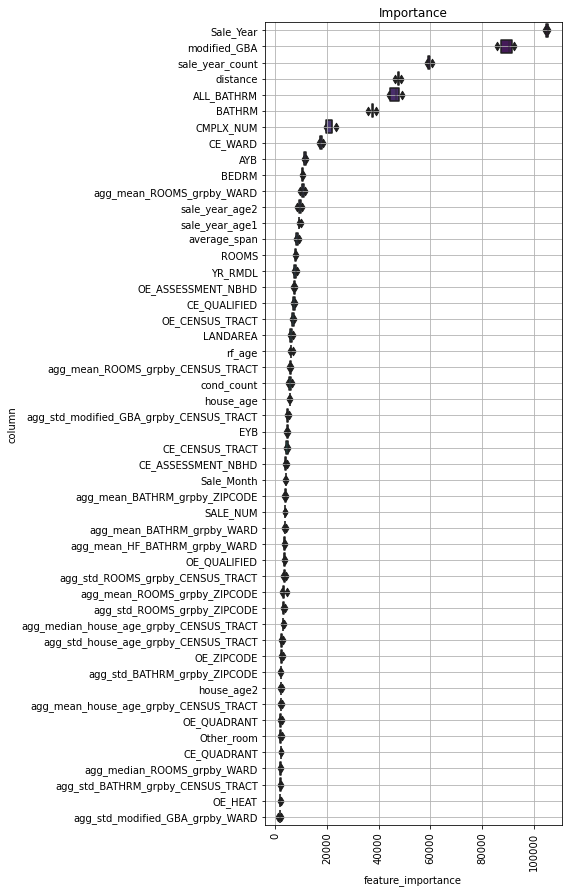

In [58]:
fig, ax = visualize_importance(models_Con, train_x_Con)

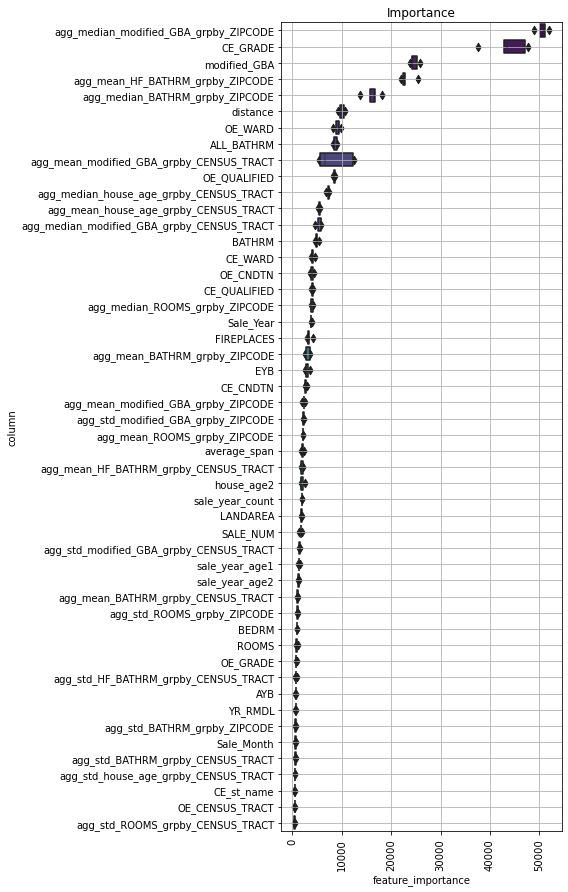

In [59]:
fig, ax = visualize_importance(models_Res, train_x_Res)

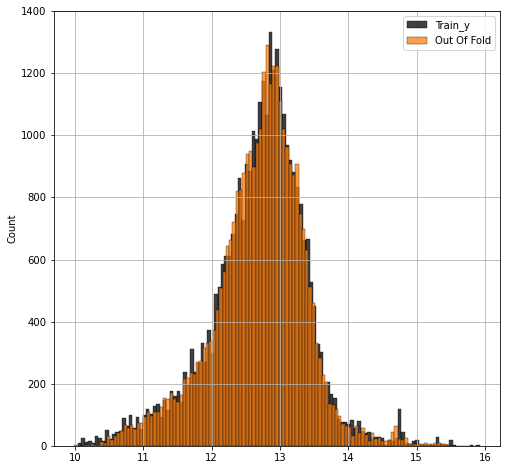

In [60]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.histplot(train_ys_Con, label='Train_y', ax=ax, color='black')
sns.histplot(oof_Con, label='Out Of Fold', ax=ax, color='C1')
ax.legend()
ax.grid()

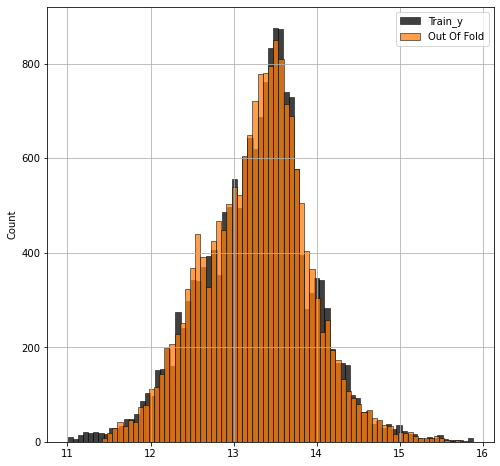

In [61]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.histplot(train_ys_Res, label='Train_y', ax=ax, color='black')
sns.histplot(oof_Res, label='Out Of Fold', ax=ax, color='C1')
ax.legend()
ax.grid()

In [62]:
# train全体でのRMSLE
pred_Con = tr_Con[["Id", "PRICE"]].copy()
pred_Res = tr_Res[["Id", "PRICE"]].copy()

pred_Con["PRICE"] = oof_Con
pred_Res["PRICE"] = oof_Res
#pred_Con["PRED_PRICE_XGB"] = oof_Con_xgb
#pred_Res["PRED_PRICE_XGB"] = oof_Res_xgb

pred_df = pd.concat([pred_Con, pred_Res], axis=0).rename(columns={"PRICE": "PRED_PRICE_LGBM"})
pred_df2 = pd.concat([tr_Con[["Id", "PRICE"]].copy(), tr_Res[["Id", "PRICE"]].copy()], axis=0)

oof_df = pd.merge(pred_df2, pred_df, on="Id", how="left")
oof_df["PRICE"] = np.log1p(oof_df["PRICE"])
oof_df["PRED_PRICE"] = oof_df["PRED_PRICE_LGBM"]
#oof_df["PRED_PRICE"] = (oof_df["PRED_PRICE_LGBM"]+oof_df["PRED_PRICE_XGB"])/2

score = mean_squared_error(oof_df["PRICE"], oof_df["PRED_PRICE"])**0.5
print("RMSLE：" + str(round(score, 4)))

RMSLE：0.2059


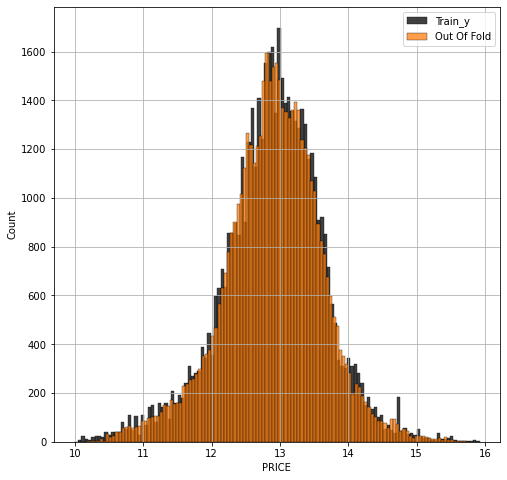

In [63]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.histplot(oof_df["PRICE"], label='Train_y', ax=ax, color='black')
sns.histplot(oof_df["PRED_PRICE"], label='Out Of Fold', ax=ax, color='C1')
ax.legend()
ax.grid()

In [64]:
pred_Con = np.array([model.predict(test_x_Con.values) for model in models_Con])
pred_Con = np.mean(pred_Con, axis=0)
pred_Con = np.where(pred_Con < 0, 0, pred_Con)
pred_Con = np.expm1(pred_Con)

In [65]:
pred_Res = np.array([model.predict(test_x_Res.values) for model in models_Res])
pred_Res = np.mean(pred_Res, axis=0)
pred_Res = np.where(pred_Res < 0, 0, pred_Res)
pred_Res = np.expm1(pred_Res)

In [66]:
submission_pred_Con = pd.DataFrame()
submission_pred_Con["Id"] = ts_Con["Id"]
submission_pred_Con["PRICE_LGBM"] = pred_Con
#submission_pred_Con["PRICE_XGB"] = pred_Con_xgb


submission_pred_Res = pd.DataFrame()
submission_pred_Res["Id"] = ts_Res["Id"]
submission_pred_Res["PRICE_LGBM"] = pred_Res
#submission_pred_Res["PRICE_XGB"] = pred_Res_xgb

submission_pred_df = pd.concat([submission_pred_Con, submission_pred_Res], axis=0)
submission_pred_df["PRICE"] = submission_pred_df["PRICE_LGBM"]

In [67]:
submission_df = pd.read_csv("../input/DC_output_sample.csv")
submission_df = submission_df.drop("PRICE", axis=1)
submission_df = pd.merge(submission_df, submission_pred_df[["Id", "PRICE"]], on="Id", how="left")

date="20210714_8"
output_dir = "../submission/"

submission_df.to_csv(output_dir + "date" + date +'submission.csv', index=False)